In [15]:
#!/usr/bin/env python3
import numpy as np

from leap_hand_utils.dynamixel_client import *
import leap_hand_utils.leap_hand_utils as lhu
import time
#######################################################
"""This can control and query the LEAP Hand

I recommend you only query when necessary and below 90 samples a second.  Each of position, velociy and current costs one sample, so you can sample all three at 30 hz or one at 90hz.

#Allegro hand conventions:
#0.0 is the all the way out beginning pose, and it goes positive as the fingers close more and more
#http://wiki.wonikrobotics.com/AllegroHandWiki/index.php/Joint_Zeros_and_Directions_Setup_Guide I belive the black and white figure (not blue motors) is the zero position, and the + is the correct way around.  LEAP Hand in my videos start at zero position and that looks like that figure.

#LEAP hand conventions:
#180 is flat out for the index, middle, ring, fingers, and positive is closing more and more.

"""

'This can control and query the LEAP Hand\n\nI recommend you only query when necessary and below 90 samples a second.  Each of position, velociy and current costs one sample, so you can sample all three at 30 hz or one at 90hz.\n\n#Allegro hand conventions:\n#0.0 is the all the way out beginning pose, and it goes positive as the fingers close more and more\n#http://wiki.wonikrobotics.com/AllegroHandWiki/index.php/Joint_Zeros_and_Directions_Setup_Guide I belive the black and white figure (not blue motors) is the zero position, and the + is the correct way around.  LEAP Hand in my videos start at zero position and that looks like that figure.\n\n#LEAP hand conventions:\n#180 is flat out for the index, middle, ring, fingers, and positive is closing more and more.\n\n'

In [24]:

########################################################
class LeapNode:
    def __init__(self):
        ####Some parameters
        # self.ema_amount = float(rospy.get_param('/leaphand_node/ema', '1.0')) #take only current
        self.kP = 600
        self.kI = 0
        self.kD = 200
        self.curr_lim = 350
        self.prev_pos = self.pos = self.curr_pos = lhu.allegro_to_LEAPhand(np.zeros(16))
           
        #You can put the correct port here or have the node auto-search for a hand at the first 3 ports.
        self.motors = motors = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
        try:
            self.dxl_client = DynamixelClient(motors, '/dev/ttyUSB2', 4000000)
            self.dxl_client.connect()
        except Exception:
            try:
                self.dxl_client = DynamixelClient(motors, '/dev/ttyUSB1', 4000000)
                self.dxl_client.connect()
            except Exception:
                self.dxl_client = DynamixelClient(motors, 'COM13', 4000000)
                self.dxl_client.connect()
        #Enables position-current control mode and the default parameters, it commands a position and then caps the current so the motors don't overload
        #self.dxl_client.sync_write(motors, np.ones(len(motors))*5, 11, 1)
        self.dxl_client.set_torque_enabled(motors, True)
        #self.dxl_client.sync_write(motors, np.ones(len(motors)) * self.kP, 84, 2) # Pgain stiffness     
        #self.dxl_client.sync_write([0,4,8], np.ones(3) * (self.kP * 0.75), 84, 2) # Pgain stiffness for side to side should be a bit less
        #self.dxl_client.sync_write(motors, np.ones(len(motors)) * self.kI, 82, 2) # Igain
        #self.dxl_client.sync_write(motors, np.ones(len(motors)) * self.kD, 80, 2) # Dgain damping
        #self.dxl_client.sync_write([0,4,8], np.ones(3) * (self.kD * 0.75), 80, 2) # Dgain damping for side to side should be a bit less
        #Max at current (in unit 1ma) so don't overheat and grip too hard #500 normal or #350 for lite
        #self.dxl_client.sync_write(motors, np.ones(len(motors)) * self.curr_lim, 102, 2)
        #self.dxl_client.write_desired_pos(self.motors, self.curr_pos)

    #Receive LEAP pose and directly control the robot
    def set_leap(self, pose):
        self.prev_pos = self.curr_pos
        self.curr_pos = np.array(pose)
        self.dxl_client.write_desired_pos(self.motors, self.curr_pos)
    #allegro compatibility
    def set_allegro(self, pose):
        pose = lhu.allegro_to_LEAPhand(pose, zeros=False)
        self.prev_pos = self.curr_pos
        self.curr_pos = np.array(pose)
        self.dxl_client.write_desired_pos(self.motors, self.curr_pos)
    #Sim compatibility, first read the sim value in range [-1,1] and then convert to leap
    def set_ones(self, pose):
        pose = lhu.sim_ones_to_LEAPhand(np.array(pose))
        self.prev_pos = self.curr_pos
        self.curr_pos = np.array(pose)
        self.dxl_client.write_desired_pos(self.motors, self.curr_pos)
    #read position
    def read_pos(self):
        return self.dxl_client.read_pos()
    #read velocity
    def read_vel(self):
        return self.dxl_client.read_vel()
    #read current
    def read_cur(self):
        return self.dxl_client.read_cur()
#init the node



In [21]:
!pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.1/159.1 kB 4.8 MB/s eta 0:00:00
  Using cached pyparsing-3.1.1-py3-none-any.whl.metadata (5.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 72.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.9/303.9 kB 85.4 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 76.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 75.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 78.3 MB/s eta 0:00:00a 0:00:01
Using cached pyparsing-3.1.1-py3-none-any.whl (103 kB)


In [22]:
leap_hand = LeapNode()
while True:
    # Fetch the current positions of all motors
    positions = leap_hand.read_pos()

    # Define the motor grouping for each finger
    finger_1_motors = [positions[i] for i in [1, 5, 9, 13]]  # Adjusted as per your definition
    finger_2_motors = [positions[i] for i in [2, 6, 10, 14]]
    finger_3_motors = [positions[i] for i in [3, 7, 11, 15]]
    thumb_motors = [positions[i] for i in [0, 4, 8, 12]]  # Thumb motors as per your new definition

    # Print the positions in a readable format
    print("Finger 1 Motors: {:.2f}, {:.2f}, {:.2f}, {:.2f}".format(*finger_1_motors))
    print("Finger 2 Motors: {:.2f}, {:.2f}, {:.2f}, {:.2f}".format(*finger_2_motors))
    print("Finger 3 Motors: {:.2f}, {:.2f}, {:.2f}, {:.2f}".format(*finger_3_motors))
    print("Thumb Motors: {:.2f}, {:.2f}, {:.2f}, {:.2f}".format(*thumb_motors))

    time.sleep(0.5)  # Adjust sleep time as necessary

Finger 1 Motors: 1.79, 2.87, 2.70, 3.03
Finger 2 Motors: 4.94, 3.14, 2.74, 2.74
Finger 3 Motors: 3.24, 4.80, 2.81, 2.97
Thumb Motors: 3.01, 4.63, 3.28, 2.96
Finger 1 Motors: 1.79, 2.87, 2.70, 3.03
Finger 2 Motors: 4.94, 3.14, 2.74, 2.74
Finger 3 Motors: 3.24, 4.80, 2.81, 2.97
Thumb Motors: 3.01, 4.63, 3.28, 2.96
Finger 1 Motors: 1.79, 2.87, 2.70, 3.03
Finger 2 Motors: 4.94, 3.14, 2.74, 2.74
Finger 3 Motors: 3.24, 4.80, 2.81, 2.97
Thumb Motors: 3.01, 4.63, 3.28, 2.96
Finger 1 Motors: 1.79, 2.87, 2.70, 3.03
Finger 2 Motors: 4.94, 3.14, 2.74, 2.74
Finger 3 Motors: 3.24, 4.80, 2.81, 2.97
Thumb Motors: 3.01, 4.63, 3.28, 2.96
Finger 1 Motors: 1.79, 2.87, 2.70, 3.03
Finger 2 Motors: 4.94, 3.14, 2.74, 2.74
Finger 3 Motors: 3.24, 4.80, 2.81, 2.97
Thumb Motors: 3.01, 4.63, 3.28, 2.96
Finger 1 Motors: 1.79, 2.87, 2.70, 3.03
Finger 2 Motors: 4.94, 3.14, 2.74, 2.74
Finger 3 Motors: 3.24, 4.80, 2.81, 2.97
Thumb Motors: 3.01, 4.63, 3.28, 2.96
Finger 1 Motors: 1.79, 2.87, 2.70, 3.03
Finger 2 Motors: 4

KeyboardInterrupt: 

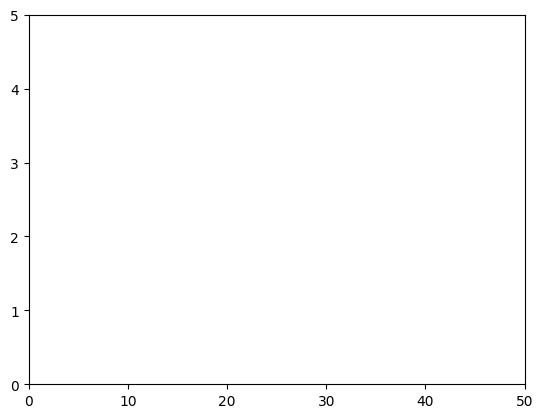

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Assuming LeapNode is defined and leap_hand is an instance of LeapNode
leap_hand = LeapNode()

# Setup the figure and axis for plotting
fig, ax = plt.subplots()
xdata, ydata = [], []
ln, = plt.plot([], [], 'r-', animated=True)

def init():
    ax.set_xlim(0, 50)  # Adjust x-axis limits
    ax.set_ylim(0, 5)  # Adjust y-axis limits to suit your motor position range
    return ln,

def update(frame):
    positions = leap_hand.read_pos()
    finger_1_positions = [positions[i] for i in [1, 5, 9, 13]]
    # For simplicity, this example uses only the first motor of Finger 1
    ydata.append(finger_1_positions[0])
    xdata.append(frame)
    
    # Keep last 50 data points
    xdata = xdata[-50:]
    ydata = ydata[-50:]
    
    ln.set_data(xdata, ydata)
    return ln,

ani = FuncAnimation(fig, update, frames=np.linspace(0, 50, 500),
                    init_func=init, blit=True)

plt.show()


In [1]:
string = """[3.500544  2.063204  5.163379  3.512816  4.396389  2.6231072 3.121651
 5.286098  4.0558453 5.026855  4.7752824 5.017651  4.6234183 3.34101
 3.6401365 3.5665054]"""

In [2]:
def print_array_with_commas(input_string):
    # Remove the brackets
    cleaned_string = input_string.strip("[]")
    
    # Split the string into elements based on spaces or line breaks
    elements = cleaned_string.split()
    
    # Convert each element into a float and store in a list
    float_elements = [float(element) for element in elements]
    
    # Print the list with commas
    print(float_elements)


In [4]:
print_array_with_commas(string)

[3.500544, 2.063204, 5.163379, 3.512816, 4.396389, 2.6231072, 3.121651, 5.286098, 4.0558453, 5.026855, 4.7752824, 5.017651, 4.6234183, 3.34101, 3.6401365, 3.5665054]
